<a href="https://colab.research.google.com/github/YapBarry/Question_Answering/blob/main/QA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question Answering using Haystack framework based on Covid 19 dataset

https://raw.githubusercontent.com/deepset-ai/COVID-QA/master/data/question-answering/COVID-QA.json

In [ ]:
# Install the latest master of Haystack
# !pip install git+https://github.com/deepset-ai/haystack.git

# If you run this notebook on Google Colab, you might need to
# restart the runtime after installing haystack.

In [ ]:
from haystack.utils import clean_wiki_text, convert_files_to_dicts, fetch_archive_from_http, print_answers
from haystack.nodes import FARMReader, TransformersReader

/usr/local/lib/python3.7/dist-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


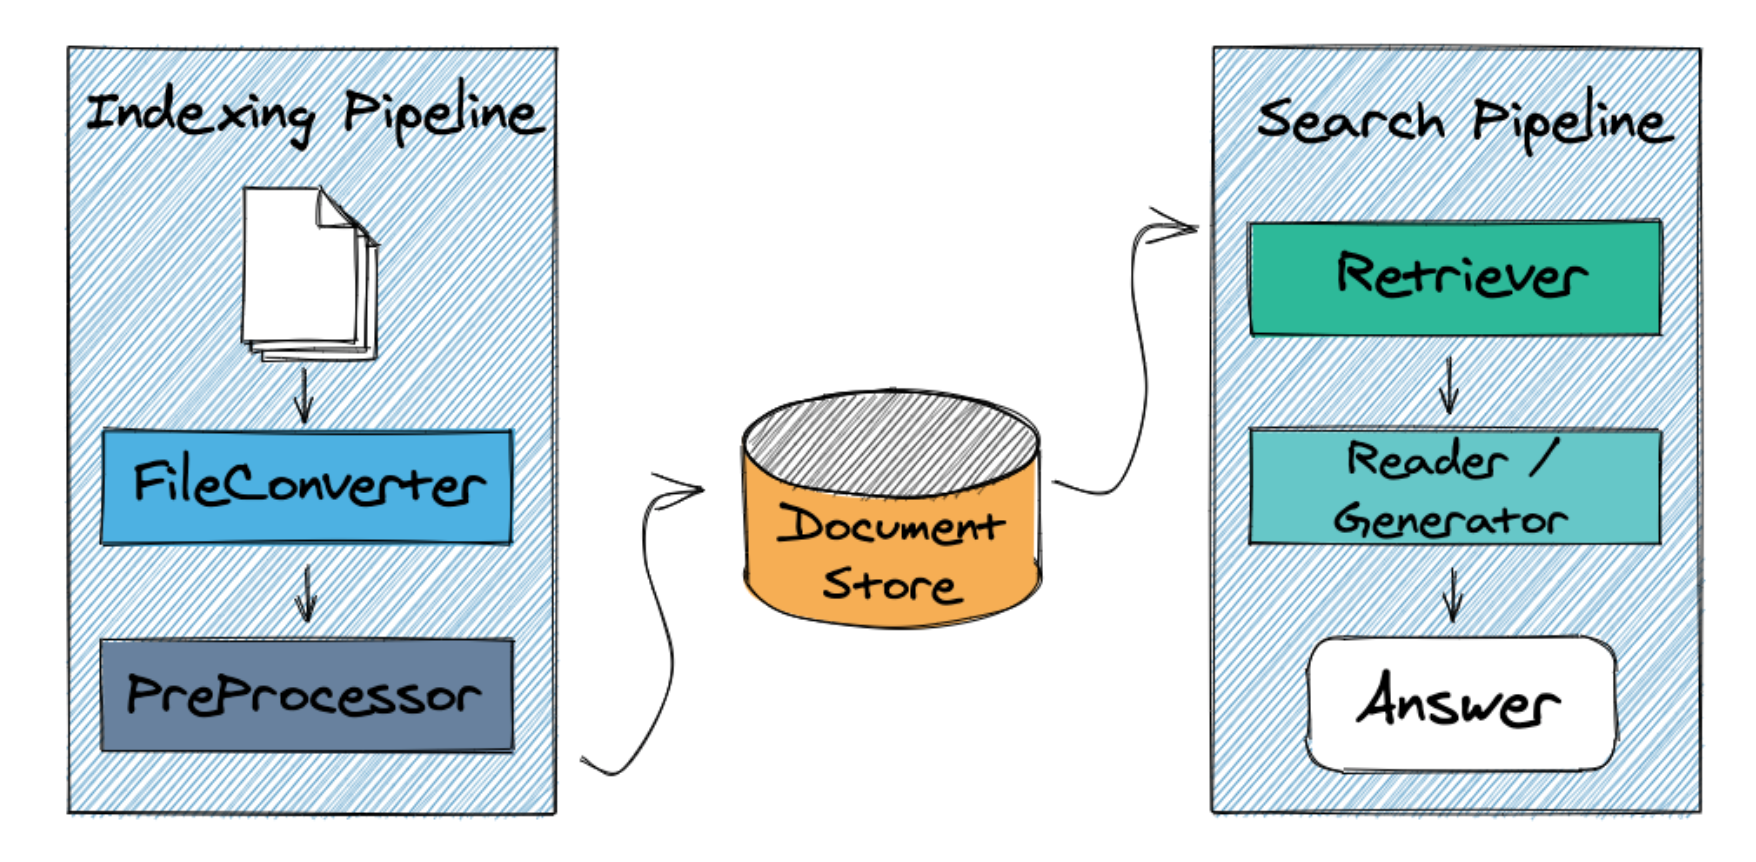

## Document Store

Haystack finds answers to queries within the documents stored in a `DocumentStore`. The current implementations of `DocumentStore` include `ElasticsearchDocumentStore`, `FAISSDocumentStore`,  `SQLDocumentStore`, and `InMemoryDocumentStore`.

**Here:** We recommended Elasticsearch as it comes preloaded with features like [full-text queries](https://www.elastic.co/guide/en/elasticsearch/reference/current/full-text-queries.html), [BM25 retrieval](https://www.elastic.co/elasticon/conf/2016/sf/improved-text-scoring-with-bm25), and [vector storage for text embeddings](https://www.elastic.co/guide/en/elasticsearch/reference/7.6/dense-vector.html).


### Start an Elasticsearch server
You can start Elasticsearch on your local machine instance using Docker. If Docker is not readily available in your environment (e.g. in Colab notebooks), then you can manually download and execute Elasticsearch from source.

In [ ]:
# # In Colab / No Docker environments: Start Elasticsearch from source
# ! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
# ! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
# ! chown -R daemon:daemon elasticsearch-7.9.2

# import os
# from subprocess import Popen, PIPE, STDOUT
# es_server = Popen(['elasticsearch-7.9.2/bin/elasticsearch'],
#                    stdout=PIPE, stderr=STDOUT,
#                    preexec_fn=lambda: os.setuid(1)  # as daemon
#                   )
# # wait until ES has started
# ! sleep 30

In [ ]:
# Connect to Elasticsearch
from haystack.document_stores import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(host="localhost", username="", password="", index="document")

## Preprocessing of documents

Haystack provides a customizable pipeline for:
 - converting files into texts
 - cleaning texts
 - splitting texts
 - writing them to a Document Store


In [ ]:
import json
json_files = json.loads(open('COVID-QA.json').read())

In [ ]:
dix = json_files['data'] # list of 147 elements
# dix[1]['paragraphs'][0]['context']

In [ ]:
# To write to ElasticSearch document store, we need the input to be a ist of dictionaries
data_json = [
    {
        'content': paragraph['paragraphs'][0]['context'],
        'meta': {
            'source': 'covid'
        }
    } for paragraph in dix
]

In [ ]:
# Checking if the output conforms to the format required by Haystacks' document_store.write_documents() function
data_json[:3]

[{'content': "Functional Genetic Variants in DC-SIGNR Are Associated with Mother-to-Child Transmission of HIV-1\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC2752805/\n\nBoily-Larouche, Geneviève; Iscache, Anne-Laure; Zijenah, Lynn S.; Humphrey, Jean H.; Mouland, Andrew J.; Ward, Brian J.; Roger, Michel\n2009-10-07\nDOI:10.1371/journal.pone.0007211\nLicense:cc-by\n\nAbstract: BACKGROUND: Mother-to-child transmission (MTCT) is the main cause of HIV-1 infection in children worldwide. Given that the C-type lectin receptor, dendritic cell-specific ICAM-grabbing non-integrin-related (DC-SIGNR, also known as CD209L or liver/lymph node–specific ICAM-grabbing non-integrin (L-SIGN)), can interact with pathogens including HIV-1 and is expressed at the maternal-fetal interface, we hypothesized that it could influence MTCT of HIV-1. METHODS AND FINDINGS: To investigate the potential role of DC-SIGNR in MTCT of HIV-1, we carried out a genetic association study of DC-SIGNR in a well-characterized 

In [ ]:
len(data_json)

147

In [ ]:
# Delete existing documents in documents store if this cell is run more than once
# As stuff from previous runs would be left in the document store and not cleared
document_store.delete_documents()

# Write documents to document store
document_store.write_documents(data_json)

In [ ]:
# !apt-get install poppler-utils


In [ ]:
# !pip install pdftotext

## Initalize Retriever, Reader,  & Pipeline

### Retriever

Retrievers help narrowing down the scope for the Reader to smaller units of text where a given question could be answered.
They use some simple but fast algorithm.

**Here:** Here we use Dense Passage Retriever

**Alternatives:**

- Customize the `ElasticsearchRetriever`with custom queries (e.g. boosting) and filters
- Use `TfidfRetriever` in combination with a SQL or InMemory Document store for simple prototyping and debugging
- Use `EmbeddingRetriever` to find candidate documents based on the similarity of embeddings (e.g. created via Sentence-BERT)
- Use `DensePassageRetriever` to use different embedding models for passage and query

In [ ]:
# using BM25
# from haystack.nodes import ElasticsearchRetriever
# retriever = ElasticsearchRetriever(document_store=document_store)

# using DPR
from haystack.retriever.dense import DensePassageRetriever
retriever = DensePassageRetriever(document_store = document_store, query_embedding_model = 'facebook/dpr-question_encoder-single-nq-base',passage_embedding_model = 'facebook/dpr-ctx_encoder-single-nq-base',embed_title=True)



INFO - haystack.modeling.utils -  Using devices: CUDA:0
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-question_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-question_encoder-single-nq-base
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find facebook/dpr-ctx_encoder-single-nq-base locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded facebook/dpr-ctx_encoder

### Reader

A Reader scans the texts returned by retrievers in detail and extracts the k best answers. They are based
on powerful, but slower deep learning models.

Haystack currently supports Readers based on the frameworks FARM and Transformers.
With both you can either load a local model or one from Hugging Face's model hub (https://huggingface.co/models).

**Here:** a medium sized RoBERTa QA model using a Reader based on FARM (https://huggingface.co/deepset/roberta-base-squad2)

**Alternatives (Reader):** TransformersReader (leveraging the `pipeline` of the Transformers package)

**Alternatives (Models):** e.g. "distilbert-base-uncased-distilled-squad" (fast) or "deepset/bert-large-uncased-whole-word-masking-squad2" (good accuracy)

**Hint:** You can adjust the model to return "no answer possible" with the no_ans_boost. Higher values mean the model prefers "no answer possible"

#### FARMReader

In [ ]:
# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2
WARNING - haystack.modeling.logger -  Failed to log params: Changing param values is not allowed. Param with key='prediction_heads' was already logged with value='TextSimilarityHead' for run ID='2cd7befad72649efa65bc91e21083050'. Attempted logging new value 'QuestionAnsweringHead'.
WARNING - haystack.modeling.logger -  Failed to log params: Changing param values is not allowed. Param with key='processor' was already logged with value='TextSimilarityProcessor' for r

### Pipeline

With a Haystack `Pipeline` you can stick together your building blocks to a search pipeline.
Under the hood, `Pipelines` are Directed Acyclic Graphs (DAGs) that you can easily customize for your own use cases.
To speed things up, Haystack also comes with a few predefined Pipelines. One of them is the `ExtractiveQAPipeline` that combines a retriever and a reader to answer our questions.
You can learn more about `Pipelines` in the [docs](https://haystack.deepset.ai/docs/latest/pipelinesmd).

In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)

In [ ]:

# Add documents embeddings to index
document_store.update_embeddings(
    retriever=retriever
)

INFO - haystack.document_stores.elasticsearch -  Updating embeddings for all 147 docs ...


Updating embeddings:   0%|          | 0/147 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/160 [00:00<?, ? Docs/s]

## Voilà! Ask a question!

## Question 1 - "What is Covid 19?"

In [ ]:
# You can configure how many candidates the reader and retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers. 
prediction = pipe.run(
    query="what is covid 19?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.55 Batches/s]


In [ ]:
# Now you can either print the object directly...
from pprint import pprint

pprint(prediction)

{'answers': [<Answer {'answer': 'coronavirus disease 2019', 'type': 'extractive', 'score': 0.8763898313045502, 'context': 'e: cc-by\n\nAbstract: IMPORTANCE: Health care workers exposed to coronavirus disease 2019 (COVID-19) could be psychologically stressed. OBJECTIVE: To as', 'offsets_in_document': [{'start': 580, 'end': 604}], 'offsets_in_context': [{'start': 63, 'end': 87}], 'document_id': 'a6c71f2c35f9c4f7a27f3cfd299dc6b', 'meta': {'source': 'covid'}}>,
             <Answer {'answer': 'Coronavirus', 'type': 'extractive', 'score': 0.6933977901935577, 'context': 'acy and security of data and people.\n\nWith scenarios like the present Coronavirus (COVID-19) outbreak, that not only impacts upon the economic status ', 'offsets_in_document': [{'start': 24501, 'end': 24512}], 'offsets_in_context': [{'start': 70, 'end': 81}], 'document_id': '70e00afee0a5ef425369491da43d04c3', 'meta': {'source': 'covid'}}>,
             <Answer {'answer': 'a novel coronavirus', 'type': 'extractive', 'score'

In [ ]:
# ...or use a util to simplify the output
# Change `minimum` to `medium` or `all` to raise the level of detail
print_answers(prediction, details="minimum")


Query: what is covid 19?
Answers:
[   {   'answer': 'coronavirus disease 2019',
        'context': 'e: cc-by\n'
                   '\n'
                   'Abstract: IMPORTANCE: Health care workers exposed to '
                   'coronavirus disease 2019 (COVID-19) could be '
                   'psychologically stressed. OBJECTIVE: To as'},
    {   'answer': 'Coronavirus',
        'context': 'acy and security of data and people.\n'
                   '\n'
                   'With scenarios like the present Coronavirus (COVID-19) '
                   'outbreak, that not only impacts upon the economic status '},
    {   'answer': 'a novel coronavirus',
        'context': 'I: 10.3390/jcm9030674\n'
                   'License: cc-by\n'
                   '\n'
                   'Abstract: In December 2019, a novel coronavirus, called '
                   'COVID-19, was discovered in Wuhan, China, and has spread'},
    {   'answer': 'coronavirus',
        'context': 'g om covid-19zlnforma

## Question 2 - "What are the symtoms of Covid 19?"

In [ ]:
# You can configure how many candidates the reader and retriever shall return
# The higher top_k_retriever, the better (but also the slower) your answers. 
prediction = pipe.run(
    query="What are the symtoms of Covid 19?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Inferencing Samples: 100%|██████████| 1/1 [00:01<00:00,  1.06s/ Batches]


In [ ]:
# Now you can either print the object directly...
from pprint import pprint

pprint(prediction)

{'answers': [<Answer {'answer': 'fever and signs and lower respiratory infections', 'type': 'extractive', 'score': 0.21751000732183456, 'context': 'mographic variables and the manifestations such as fever and signs and lower respiratory infections, including cough and SOB in individuals defined as', 'offsets_in_document': [{'start': 4296, 'end': 4344}], 'offsets_in_context': [{'start': 51, 'end': 99}], 'document_id': 'dc2a1c0651d72126de59f4a02a398dd0', 'meta': {'source': 'covid'}}>,
             <Answer {'answer': 'severe symptoms', 'type': 'extractive', 'score': 0.21514034271240234, 'context': 'kers were 1.4 times more likely (RR=1.4, 95% CI: 0.98–2.00) to have severe symptoms of COVID-19 and approximately 2.4 times more likely to be admitted', 'offsets_in_document': [{'start': 6089, 'end': 6104}], 'offsets_in_context': [{'start': 68, 'end': 83}], 'document_id': '1ed984c24582f2a94bf38fdecbc92015', 'meta': {'source': 'covid'}}>,
             <Answer {'answer': 'severity of the disease,

In [ ]:
# ...or use a util to simplify the output
# Change `minimum` to `medium` or `all` to raise the level of detail
print_answers(prediction, details="minimum")


Query: What are the symtoms of Covid 19?
Answers:
[   {   'answer': 'fever and signs and lower respiratory infections',
        'context': 'mographic variables and the manifestations such as fever '
                   'and signs and lower respiratory infections, including '
                   'cough and SOB in individuals defined as'},
    {   'answer': 'severe symptoms',
        'context': 'kers were 1.4 times more likely (RR=1.4, 95% CI: '
                   '0.98–2.00) to have severe symptoms of COVID-19 and '
                   'approximately 2.4 times more likely to be admitted'},
    {   'answer': 'severity of the disease, the need for mechanical '
                  'ventilation, the need for intensive care unit (ICU) '
                  'hospitalization and death',
        'context': 'cluding the severity of the disease, the need for '
                   'mechanical ventilation, the need for intensive care unit '
                   '(ICU) hospitalization and death. The litera'}

In [ ]:
print_answers(prediction)


Query: What are the symtoms of Covid 19?
Answers:
[   <Answer {'answer': 'fever and signs and lower respiratory infections', 'type': 'extractive', 'score': 0.21751000732183456, 'context': 'mographic variables and the manifestations such as fever and signs and lower respiratory infections, including cough and SOB in individuals defined as', 'offsets_in_document': [{'start': 4296, 'end': 4344}], 'offsets_in_context': [{'start': 51, 'end': 99}], 'document_id': 'dc2a1c0651d72126de59f4a02a398dd0', 'meta': {'source': 'covid'}}>,
    <Answer {'answer': 'severe symptoms', 'type': 'extractive', 'score': 0.21514034271240234, 'context': 'kers were 1.4 times more likely (RR=1.4, 95% CI: 0.98–2.00) to have severe symptoms of COVID-19 and approximately 2.4 times more likely to be admitted', 'offsets_in_document': [{'start': 6089, 'end': 6104}], 'offsets_in_context': [{'start': 68, 'end': 83}], 'document_id': '1ed984c24582f2a94bf38fdecbc92015', 'meta': {'source': 'covid'}}>,
    <Answer {'answer': '

In [ ]:
prediction['answers'][0]

<Answer {'answer': 'fever and signs and lower respiratory infections', 'type': 'extractive', 'score': 0.21751000732183456, 'context': 'mographic variables and the manifestations such as fever and signs and lower respiratory infections, including cough and SOB in individuals defined as', 'offsets_in_document': [{'start': 4296, 'end': 4344}], 'offsets_in_context': [{'start': 51, 'end': 99}], 'document_id': 'dc2a1c0651d72126de59f4a02a398dd0', 'meta': {'source': 'covid'}}>

## Future Work

Based on the answer with the highest confidence, we can decide if it is good enough or not. In this case, when we asked the question "is covid 19 deadly?", the best answer only has a confidence of 41.9% as seen above.

We could add on this and search an online database like wikipedia using **wikipedia api** to get an answer to see if it is more accurate. This could be done by obtaining the confidence score above using regex maybe (not able to just get the score by prediction['answers'][0]['score'] as haystack answer object is not subscriptable).